<a href="https://colab.research.google.com/github/amayafukai/Clothes_Price_Prediction/blob/master/Clothes_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/data'

Mounted at /content/gdrive
/content/gdrive/MyDrive/data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load dữ liệu

In [ ]:
data = pd.read_csv('clothes_price_prediction_data.csv')

 # Hiển thị mô tả dữ liệu

In [ ]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Brand     1000 non-null   object
 1   Category  1000 non-null   object
 2   Color     1000 non-null   object
 3   Size      1000 non-null   object
 4   Material  1000 non-null   object
 5   Price     1000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 47.0+ KB
None
             Price
count  1000.000000
mean    106.289000
std      53.695444
min      10.000000
25%      59.750000
50%     108.000000
75%     150.000000
max     199.000000
Brand       0
Category    0
Color       0
Size        0
Material    0
Price       0
dtype: int64


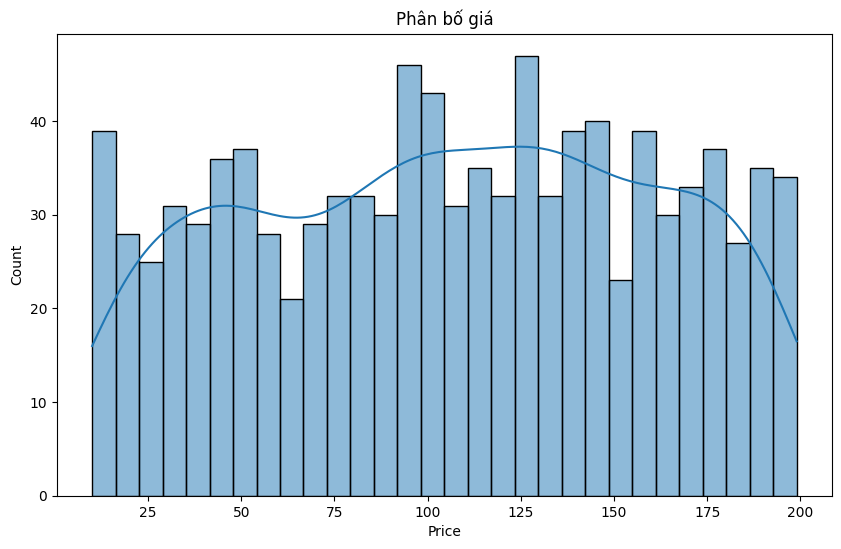

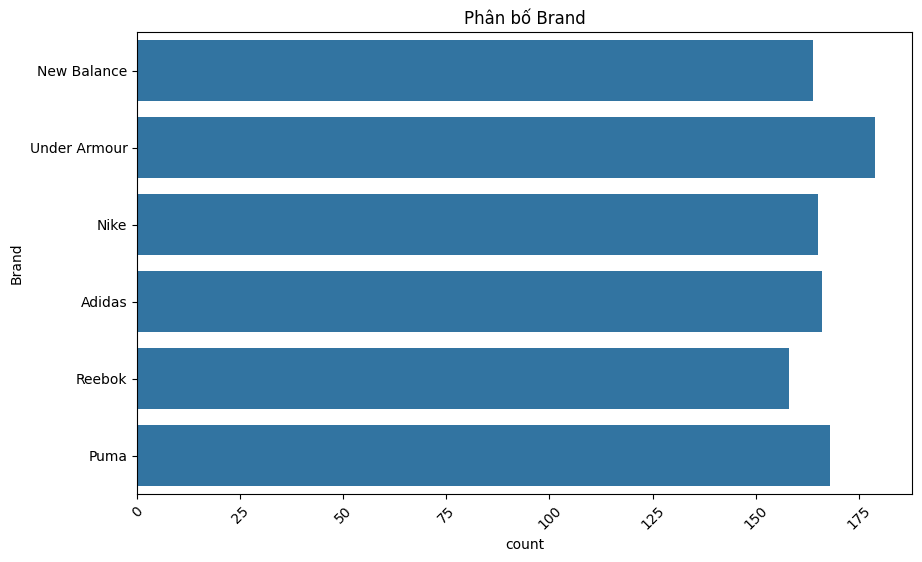

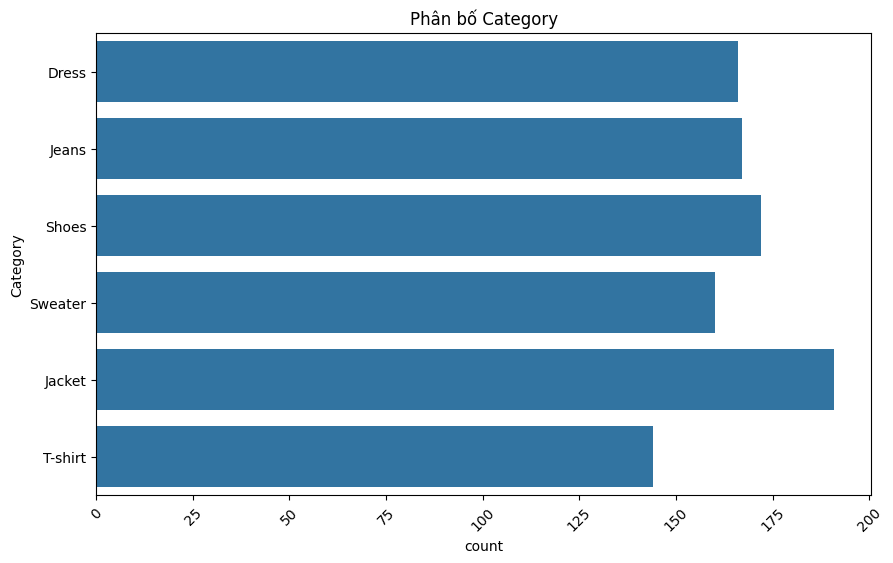

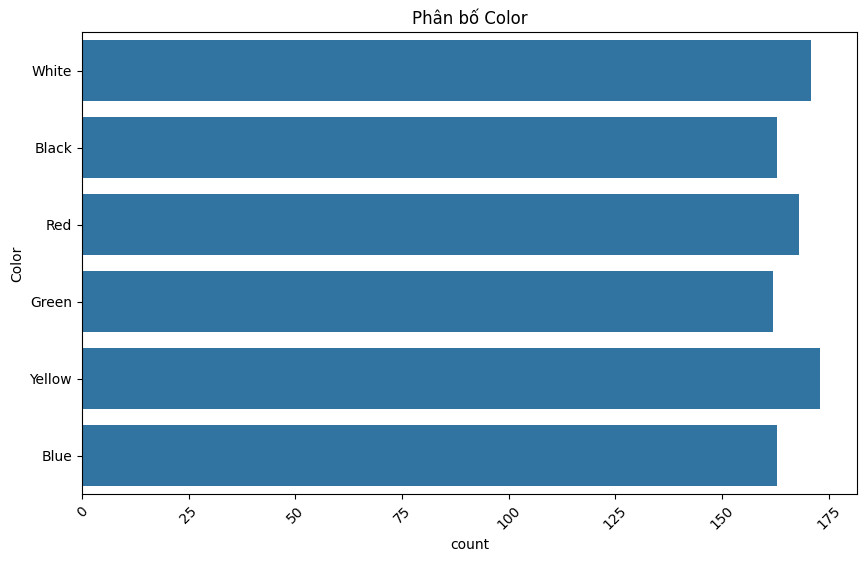

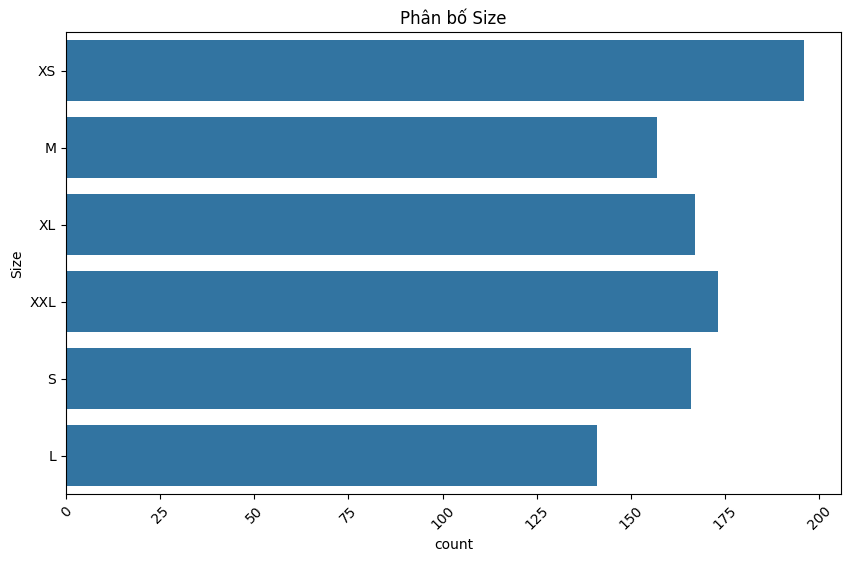

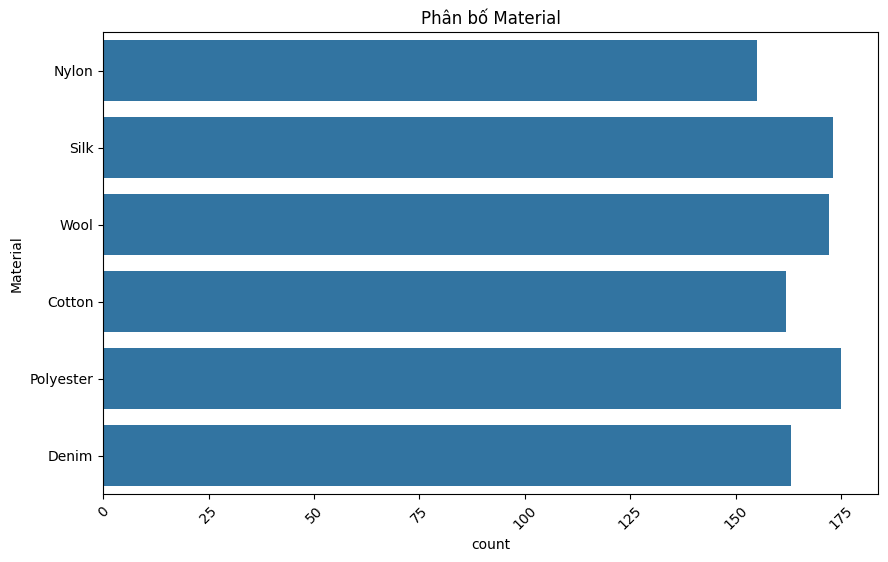

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], bins=30, kde=True)
plt.title('Phân bố giá')
plt.show()

for column in ['Brand', 'Category', 'Color', 'Size', 'Material']:
    plt.figure(figsize=(10, 6))
    sns.countplot(data[column])
    plt.title(f'Phân bố {column}')
    plt.xticks(rotation=45)
    plt.show()

# Tiền xử lý dữ liệu

In [ ]:
for column in data.columns:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].mode()[0], inplace=True)

In [ ]:
categorical_features = ['Brand', 'Category', 'Color', 'Size', 'Material']
numerical_features = []  #  'Price'

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Phân chia dữ liệu

In [ ]:
X = data.drop('Price', axis=1)
y = data['Price']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập xác thực:", X_val.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

Kích thước tập huấn luyện: (700, 5)
Kích thước tập xác thực: (150, 5)
Kích thước tập kiểm tra: (150, 5)


# Định nghĩa các tham số

In [ ]:
nn_params = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
             'activation': ['tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'alpha': [0.0001, 0.05],
             'learning_rate': ['constant','adaptive']}

rf_params = {'n_estimators': [100, 200],
             'max_depth': [10, 20, None],
             'min_samples_split': [2, 5, 10]}

dt_params = {'max_depth': [10, 20, None],
             'min_samples_split': [2, 5, 10]}

# Tạo GridSearchCV

In [ ]:
nn = MLPRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
grid_nn = GridSearchCV(nn, nn_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt = GridSearchCV(dt, dt_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Sử dụng pipeline để kết hợp các bước tiền xử lý và huấn luyện mô hình

In [ ]:
pipeline_nn = Pipeline(steps=[('preprocessor', preprocessor),
                              ('grid_nn', grid_nn)])
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('grid_rf', grid_rf)])
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('grid_dt', grid_dt)])


# Huấn luyện và đánh giá hiệu suất của các mô hình

In [ ]:
models = [pipeline_nn, pipeline_rf, pipeline_dt]
model_names = ['Neural Network', 'Random Forest', 'Decision Tree']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

# kết quả thực nghiệm

In [ ]:
results = {}

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': round(mean_absolute_error(y_test, y_pred), 3),
        'MSE': round(mean_squared_error(y_test, y_pred), 3),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
        'R2': round(r2_score(y_test, y_pred), 3)
    }

In [ ]:
result_df = pd.DataFrame(results).T
print(result_df)

                   MAE       MSE    RMSE     R2
Neural Network  46.459  2953.193  54.343 -0.019
Random Forest   47.672  3202.633  56.592 -0.105
Decision Tree   53.150  4136.382  64.315 -0.428
